In [383]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), "../../../filecoin-mecha-twin"))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

In [3]:
# for time-series prediction - SGT model
#  https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html 

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

import jax.numpy as jnp
import jax.random as random
from numpyro.infer import MCMC, NUTS, Predictive

def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150
    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

## 1. Parameters and other variables

In [4]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# Today is 2022-11-01  # TODO: update
current_date = datetime.date(2022, 11, 1)   
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-01
2024-10-31


## 2. Input data

#### Sector scheduled expirations

In [112]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               384714480.309213
mined_fil                     233855840.958391
vested_fil                    301765965.131562
locked_fil                    134508108.842877
burnt_fil                      33465835.899636
date                                2022-11-01
total_raw_power_eib                  16.017958
total_qa_power_eib                    18.62947
day_onboarded_rb_power_pib            9.494843
day_onboarded_qa_power_pib            25.90319
day_renewed_qa_power_pib            117.858355
Name: 595, dtype: object

In [7]:
fil_stats_df

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,30.751831,30.778159,0.000000
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,31.845703,31.854920,0.000000
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.429504,31.464130,0.000000
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.384003,31.454148,0.000000
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.441833,32.462359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
591,3.796988e+08,2.327454e+08,3.006940e+08,1.373614e+08,3.344580e+07,2022-10-28,16.433664,18.964574,10.004333,31.373912,29.607756
592,3.802024e+08,2.330227e+08,3.009620e+08,1.373912e+08,3.345772e+07,2022-10-29,16.429978,18.990635,9.717072,32.868684,34.120605
593,3.807408e+08,2.332989e+08,3.012300e+08,1.373957e+08,3.345893e+07,2022-10-30,16.426456,19.008181,9.345123,27.947378,31.115140
594,3.822313e+08,2.335827e+08,3.014980e+08,1.364553e+08,3.346076e+07,2022-10-31,16.280976,18.863566,9.063538,22.361592,32.562458


## 1.5 - Use Time-Series prediction methods to power forecasting inputs

In [596]:
num_days_train = 180
quick_run = False
if quick_run:
    num_warmup_mcmc = 500
    num_samples_mcmc = 100
else:
    num_warmup_mcmc = 5000
    num_samples_mcmc = 1000

### 1.5.1 - Forecast rb_onboard_power

In [597]:
x_train = fil_stats_df.index.values[-num_days_train:]
xx_train = fil_stats_df.date[-num_days_train:]
y_train_rb_onboard = jnp.array(fil_stats_df['day_onboarded_rb_power_pib'].values[-num_days_train:])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_rb_onboard, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
rawbyte_onboard_dist = predictive(random.PRNGKey(1), y_train, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

sample: 100%|████████████████████████████████████████████████| 6000/6000 [01:15<00:00, 79.17it/s, 63 steps of size 2.92e-02. acc. prob=0.82]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.08      0.09     -0.05     -0.21      0.00    886.88      1.00
       init_s[0]     -1.57     71.75      0.06    -37.57     35.02   2160.39      1.00
       init_s[1]      1.59      0.67      1.59      0.47      2.55   1420.03      1.00
       init_s[2]      1.73      0.78      1.71      0.56      2.89   1357.03      1.00
       init_s[3]      1.44      0.81      1.43      0.22      2.67   1275.00      1.00
       init_s[4]      0.71      0.89      0.70     -0.64      2.09    993.19      1.00
       init_s[5]      2.15      0.96      2.15      0.60      3.63    996.54      1.00
       init_s[6]      1.77      0.94      1.77      0.28      3.27    995.38      1.00
       init_s[7]      0.45      1.00      0.43     -1.17      1.99    899.78      1.00
       init_s[8]      0.32      1.01      0.30     -1.34      1.89    813.50      1.00
       init_s[9]     -1.15      1.06     -

Text(0, 0.5, 'PiB')

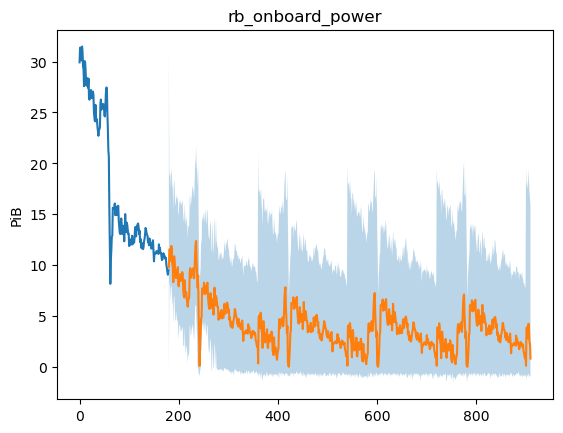

In [598]:
y_pred_rb_onboard_power = jnp.median(rawbyte_onboard_dist, axis=0)
hpd_low, hpd_high = hpdi(rawbyte_onboard_dist)
x_pred = np.arange(len(y_train_rb_onboard), len(y_pred_rb_onboard_power) + len(y_train_rb_onboard))
# fil_stats_df['day_onboarded_rb_power_pib'].plot(); plt.title('Onboarding PiB')
plt.plot(np.arange(len(y_train_rb_onboard)), y_train_rb_onboard)
plt.plot(x_pred, y_pred_rb_onboard_power)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)
plt.title('rb_onboard_power')
plt.ylabel('PiB')
# plt.xlim(0,720)

### 1.5.2 - renewal_rate

In [599]:
# sector_expirations_df = query_starboard_sector_expirations(start_date, current_date)

# df_extend_subset = sector_expirations_df.copy()

# ### predict extensions
# y_train_extend = jnp.clip(jnp.array(df_extend_subset['extended_rb'].values), a_min=0.01, a_max=None)[-num_days_train:]

# kernel = NUTS(sgt)
# mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
# mcmc.run(random.PRNGKey(0), y_train_extend, seasonality=1000)
# mcmc.print_summary()
# samples = mcmc.get_samples()

# predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
# forecast_extend = predictive(random.PRNGKey(1), y_train_extend, seasonality=1000, future=forecast_lenght)[
#     "y_forecast"
# ]
# y_pred_extend = jnp.median(forecast_marginal_extend, axis=0)
# hpd_low_extend, hpd_high_extend = hpdi(forecast_marginal_extend)

In [600]:
# ### predict expirations
# y_train_expire = jnp.clip(jnp.array(df_extend_subset['expired_rb'].values), a_min=0.01, a_max=None)[-num_days_train:]
# kernel = NUTS(sgt)
# mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
# mcmc.run(random.PRNGKey(0), y_train_expire, seasonality=1000)
# mcmc.print_summary()
# samples = mcmc.get_samples()

# predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
# forecast_expire = predictive(random.PRNGKey(1), y_train_expire, seasonality=1000, future=forecast_lenght)[
#     "y_forecast"
# ]
# y_pred_expire = jnp.median(forecast_marginal_expire, axis=0)
# hpd_low_expire, hpd_high_expire = hpdi(forecast_marginal_expire)

In [601]:
df_renewal_rate_orig = pd.read_csv('offline_info/Scheduled_Expiration_by_Date_Breakdown_in_PiB.csv')
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]

y_train_extend = jnp.array(df_renewal_rate['Extend'].values)[-num_days_train:]

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_extend, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_extend = predictive(random.PRNGKey(1), y_train_extend, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_extend = jnp.median(forecast_extend, axis=0)
hpd_low_extend, hpd_high_extend = hpdi(forecast_extend)


y_train_expire = jnp.array(df_renewal_rate['Expired'].values)
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_expire, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_expire = predictive(random.PRNGKey(1), y_train_expire, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_expire = jnp.median(forecast_expire, axis=0)
hpd_low_expire, hpd_high_expire = hpdi(forecast_expire)

sample: 100%|██████████████████████████████████████████████| 6000/6000 [00:54<00:00, 109.59it/s, 127 steps of size 1.71e-02. acc. prob=0.98]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.40      0.35      0.31      0.01      0.93    431.37      1.00
       init_s[0]      0.26     28.19      0.25    -38.51     21.30   1053.32      1.00
       init_s[1]     -0.79      0.86     -0.78     -2.20      0.56   1258.71      1.00
       init_s[2]     -0.43      0.89     -0.40     -1.79      1.06   1425.15      1.00
       init_s[3]     -0.44      0.91     -0.43     -2.01      0.94   1400.74      1.00
       init_s[4]      2.45      0.97      2.46      0.74      3.93   1198.78      1.00
       init_s[5]      5.82      1.05      5.88      4.12      7.54    955.72      1.00
       init_s[6]     27.80      1.20     27.80     25.85     29.64    745.60      1.00
       init_s[7]     -0.88      1.04     -0.86     -2.48      0.87   1176.98      1.00
       init_s[8]      0.31      1.09      0.31     -1.46      2.01    956.92      1.00
       init_s[9]      8.09      1.14      

sample: 100%|███████████████████████████████████████████████| 6000/6000 [00:42<00:00, 140.24it/s, 63 steps of size 6.56e-02. acc. prob=0.76]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.20      0.16      0.16      0.00      0.44    759.47      1.00
       init_s[0]     -1.38     17.16      0.00    -19.24     20.46    398.29      1.00
       init_s[1]     -0.29      0.59     -0.30     -1.20      0.75   1171.53      1.00
       init_s[2]      0.26      0.67      0.23     -0.82      1.32   1298.76      1.00
       init_s[3]     -1.56      0.73     -1.61     -2.68     -0.28   1092.62      1.00
       init_s[4]      1.39      0.72      1.38      0.24      2.53   1220.17      1.00
       init_s[5]     -1.07      0.72     -1.08     -2.19      0.14   1091.14      1.00
       init_s[6]     13.16      0.88     13.15     11.80     14.55    817.25      1.00
       init_s[7]     -1.82      0.78     -1.84     -3.04     -0.53   1034.54      1.00
       init_s[8]     -0.47      0.75     -0.48     -1.66      0.80    879.59      1.00
       init_s[9]     20.44      0.85     2

In [602]:
renewal_dist = forecast_extend / (forecast_extend + forecast_expire)
y_pred_renewal = jnp.median(renewal_dist, axis=0)

Text(0, 0.5, 'Renewal Rate')

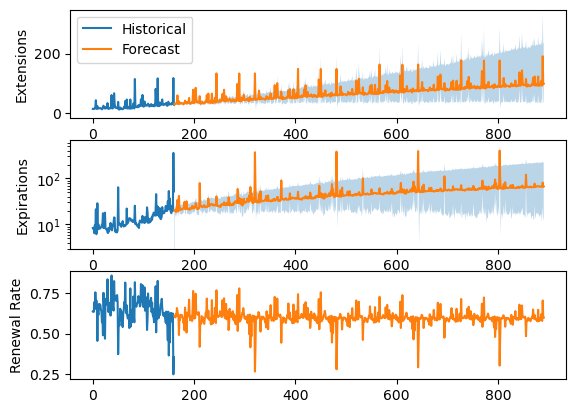

In [603]:
plt.figure()
plt.subplot(3,1,1)
x_pred = np.arange(len(y_train_extend), len(y_pred_extend) + len(y_train_extend))
plt.plot(np.arange(len(y_train_extend)), y_train_extend, label='Historical')
plt.plot(x_pred, y_pred_extend, label='Forecast')
plt.fill_between(x_pred, hpd_low_extend, hpd_high_extend, alpha=0.3)
plt.legend()
plt.ylabel('Extensions')

plt.subplot(3,1,2)
x_pred = np.arange(len(y_train_expire), len(y_pred_expire) + len(y_train_expire))
plt.plot(np.arange(len(y_train_expire)), y_train_expire)
plt.plot(x_pred, y_pred_expire)
plt.fill_between(x_pred, hpd_low_expire, hpd_high_expire, alpha=0.3)
plt.yscale('log')
plt.ylabel('Expirations')

plt.subplot(3,1,3)
plt.plot(np.arange(len(y_train_expire)), y_train_extend/(y_train_extend+y_train_expire))
plt.plot(x_pred, y_pred_renewal)
plt.ylabel('Renewal Rate')

### 1.5.3 - FIL+

In [604]:
# TODO: update to download data directly from starboard
df_deals_orig = pd.read_csv('offline_info/Daily_Active_Deal_TiB_Change_Breakdown.csv')
df_deals = df_deals_orig.copy()
df_deals['deals_onboard'] = df_deals['New Active Deal'] / 1024
df_deals = df_deals[df_deals.stateTime <= str(current_date)]

y_train_deals = jnp.array(df_deals.deals_onboard.values)[-num_days_train:]

print(jnp.argsort(autocorrelation(y_train))[::-1])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_deals, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
deal_onboard_dist = predictive(random.PRNGKey(1), y_train_deals, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  64  65  63  66  67  60  62  61  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 127 126 128
 123 129 125 130 124 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 179 173 174 175 178 176 177]


sample: 100%|███████████████████████████████████████████████| 6000/6000 [00:25<00:00, 232.13it/s, 63 steps of size 6.65e-02. acc. prob=0.91]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.01      0.01      0.01     -0.00      0.02   1014.10      1.00
       init_s[0]      0.02      0.69      0.00     -0.76      0.62   1100.25      1.00
       init_s[1]      0.11      0.12      0.10     -0.06      0.32   1783.76      1.00
       init_s[2]     -0.02      0.11     -0.01     -0.19      0.14   1691.34      1.00
       init_s[3]     -0.09      0.13     -0.06     -0.31      0.09   1131.20      1.00
       init_s[4]      0.02      0.11      0.01     -0.15      0.19   1355.75      1.00
       init_s[5]     -0.16      0.19     -0.11     -0.47      0.08    627.77      1.00
       init_s[6]     -0.08      0.15     -0.04     -0.34      0.12   1184.57      1.00
       init_s[7]      0.27      0.26      0.21     -0.10      0.72    868.59      1.00
       init_s[8]      0.15      0.18      0.12     -0.11      0.41    722.14      1.00
       init_s[9]     -0.03      0.10     -

Text(0.5, 0, 'days')

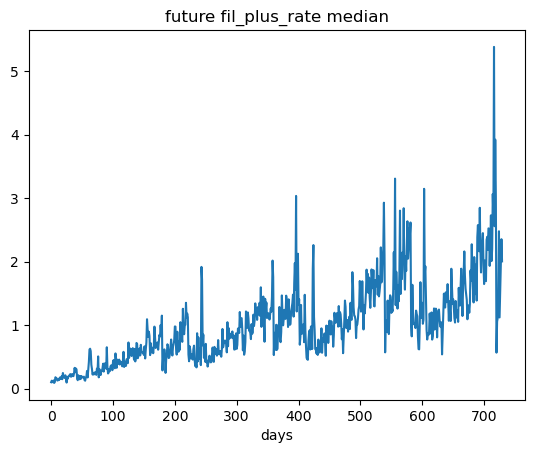

In [605]:
fil_plus_rate_dist = deal_onboard_dist / rawbyte_onboard_dist 
y_fil_plus_rate_pred = jnp.median(fil_plus_rate_dist, axis=0)
plt.plot(y_fil_plus_rate_pred)
plt.title('future fil_plus_rate median'); plt.xlabel('days')

## Choose Power Forecasting Scenario

In [629]:
"""
NOTE: renewal_rate_vec needs to be a vector of the same length as the entire simulation (end_day-start_day),
but rb_onboard_power_pred and fil_plus_rate_pred need to be of length as the forecast amount (end_day-current_day)

TODO: Consider making this a smoother and more intuitive API, right now it is not.
"""

# can be static, mcmc-forecast, or other options that you insert
input_mode = 'static'  
duration = 360

sector_expirations_df = query_starboard_sector_expirations(start_date, current_date)
historical_renewal_rate = sector_expirations_df['extended_rb'] / (sector_expirations_df['extended_rb'] + sector_expirations_df['expired_rb'] + sector_expirations_df['open_rb'])
historical_renewal_rate = historical_renewal_rate.values

# set baselines for static projections
# #### OLD values
baseline_future_renewal_rate_val = 0.6
baseline_onboarding_rate = 12
baseline_filplus_rate = 0.098

# #### NEW: take median of historical data
# baseline_future_renewal_rate_val = np.median(historical_renewal_rate[-num_days_train:])
# baseline_onboarding_rate = np.median(fil_stats_df['day_onboarded_rb_power_pib'].values[-num_days_train:])
# fp_pred_len = min(len(y_train_deals), len(y_train_rb_onboard), num_days_train)
# baseline_filplus_rate = np.median(y_train_deals[-fp_pred_len:]/y_train_rb_onboard[-fp_pred_len:])

if input_mode == 'static':
    # Renewal rate must now be a vector the length of the simulation
#     future_renewal_rate_val = historical_renewal_rate[-1]
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif input_mode == 'mcmc-forecast':
    # setup prediction vectors
    renewal_rate_vec_pred = y_pred_renewal
    renewal_rate_vec = np.concatenate([historical_renewal_rate,renewal_rate_vec_pred])
    rb_onboard_power_pred = y_pred_rb_onboard_power
    fil_plus_rate_pred = y_fil_plus_rate_pred
    
    plt_title_str = 'MCMC[Warmup=%d,Samples=%d]' % (num_warmup_mcmc, num_samples_mcmc)
elif input_mode == 'onboarding-drop-static':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*0.1
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Drop-Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif input_mode == 'onboarding-drop-linear':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = np.linspace(baseline_onboarding_rate, baseline_onboarding_rate*0.1, forecast_lenght)
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Drop-Linear[RR=%0.03f,Onboard=(%0.02f,%0.02f),FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], baseline_onboarding_rate, baseline_onboarding_rate*0.1, fil_plus_rate_pred)
elif input_mode == 'onboarding-increase-static':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*2
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Increase-Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif input_mode == 'onboarding-increase-linear':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*2
    rb_onboard_power_pred = np.linspace(baseline_onboarding_rate, baseline_onboarding_rate*2, forecast_lenght)
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Increase-Linear[RR=%0.03f,Onboard=(%0.02f,%0.02f),FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], baseline_onboarding_rate, baseline_onboarding_rate*2, fil_plus_rate_pred)
else:
    raise Exception("Bad input_mode selected!")

## 2. Forecast power stats

In [630]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power_pred,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate_vec_pred[-int(forecast_lenght):],
    fil_plus_rate_pred,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [631]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

print(len(power_df))
power_df.head()

1326


,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-03-15,3.310809,3.311754,30.778159,0.0
1,2021-03-16,3.310809,3.311754,30.778159,0.0
2,2021-03-17,3.341048,3.341986,31.854920,0.0
3,2021-03-18,3.369592,3.370540,31.464130,0.0
4,2021-03-19,3.396884,3.397818,31.454148,0.0


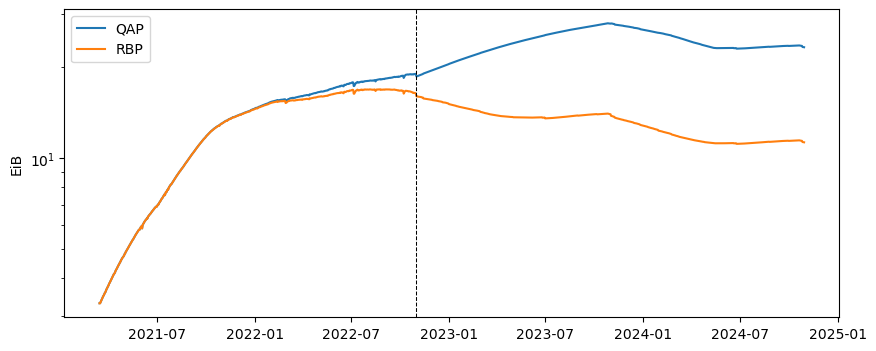

In [632]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.axvline(power_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("EiB")
plt.legend()
plt.yscale('log')
plt.show()


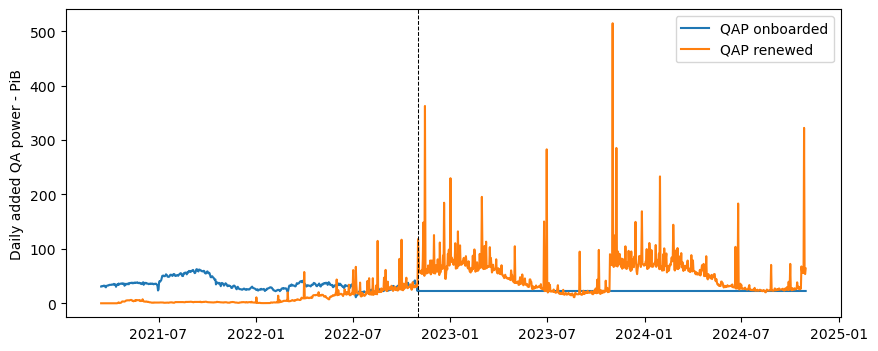

In [633]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("Daily added QA power - PiB")
plt.legend()
plt.show()

## 3. Forecast Vesting

In [634]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

print(len(vest_df))
vest_df.head()

1326


,date,total_vest
151,2021-03-15,1.093991e+08
152,2021-03-16,1.100472e+08
153,2021-03-17,1.106954e+08
154,2021-03-18,1.113435e+08
155,2021-03-19,1.119917e+08


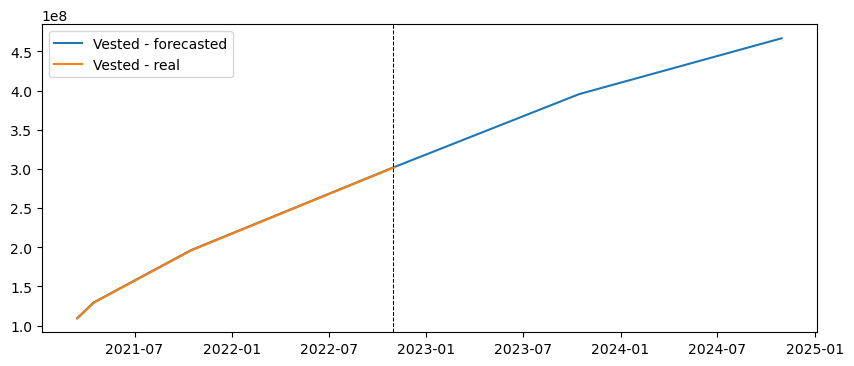

In [635]:
plt.figure(figsize=(10,4))
plt.plot(vest_df["date"], vest_df['total_vest'], label="Vested - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['vested_fil'],label="Vested - real")
plt.axvline(vest_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 4. Forecast minting stats and baseline

In [636]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

#### check network time

In [637]:
# if need to pull data to check network time
# from sqlalchemy import create_engine

# CONFIG_STRING_PATH = '../../../Data/Sentinel/config/sentinel_config.txt'
# with open(CONFIG_STRING_PATH, 'r') as fid:
#     conn_string = fid.read()
#     engine = create_engine(conn_string)
    
# model_ = 'chain_rewards'
# QUERY = f"""
# SELECT 
# to_timestamp(height_to_unix(height)) AS timestamp, cum_sum_baseline, cum_sum_realized, effective_baseline_power, new_baseline_power, total_mined_reward, effective_network_time 
# FROM visor.{model_}
# """
# pd.read_sql(QUERY, engine).to_csv(f'../../../Data/Sentinel/{model_}.csv')
# df_rewards_orig = pd.read_csv(f'../../../Data/Sentinel/{model_}.csv')

# rewards_df = df_rewards_orig.copy()
# rewards_df = rewards_df.sort_values("timestamp").reset_index()
# rewards_df['date'] = pd.to_datetime(rewards_df.timestamp, format='%Y-%m-%d')
# rewards_df = rewards_df.groupby(rewards_df.date.dt.date).mean() # daily so lighter weight
# rewards_df.index = pd.to_datetime(rewards_df.index, format='%Y-%m-%d')
# rewards_df.to_csv('../offline_info/chain_rewards.csv')

In [638]:
rewards_df = pd.read_csv('offline_info/chain_rewards.csv', parse_dates=['date'])
rewards_df = rewards_df[rewards_df.date >= str(start_date)]
rewards_df.index = rewards_df.date

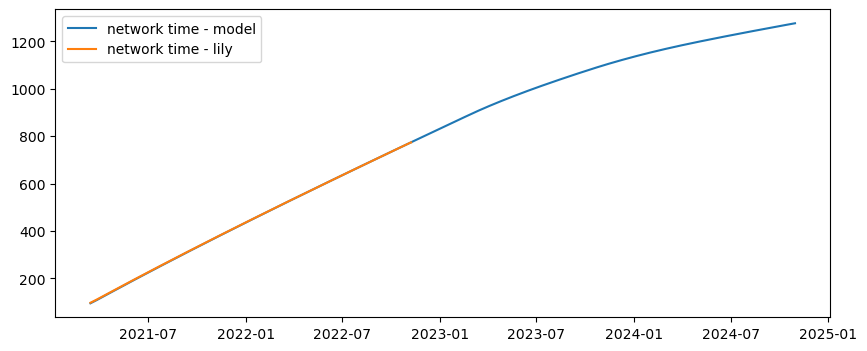

In [639]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['network_time'], label="network time - model")
plt.plot(rewards_df.date, rewards_df["effective_network_time"]/(60*24*2), label="network time - lily");
plt.legend()
plt.show()

#### check baseline crossing

In [640]:
assert len(power_df) == len(mint_df)
assert power_df.iloc[0]['date'] == mint_df.iloc[0]['date']

baseline_df = pd.DataFrame({
    'date': mint_df.date,
    'baseline_storage': baseline_storage(mint_df.days * EPOCH_PER_DAY)}
)

rb_crossing_above = power_df[power_df["total_raw_power_eib"] > baseline_df['baseline_storage']]["date"].iloc[0]
power_df_afterfirstcrossing = power_df[power_df['date'] > pd.to_datetime(rb_crossing_above)]
baseline_df_afterfirstcrossing = baseline_df[baseline_df['date'] > pd.to_datetime(rb_crossing_above)]
rb_crossing_below = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_raw_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]["date"].iloc[0]
qa_crossing_below_df = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_qa_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]
if len(qa_crossing_below_df) > 0:
    qa_crossing_below = qa_crossing_below_df["date"].iloc[0]
else:
    qa_crossing_below = None

print(rb_crossing_above)
print(rb_crossing_below)
print(qa_crossing_below)

2021-04-02
2023-02-28
2024-01-15


Text(0.5, 1.0, 'Static[RR=0.600,Onboard=12.00,FIL+=0.098]')

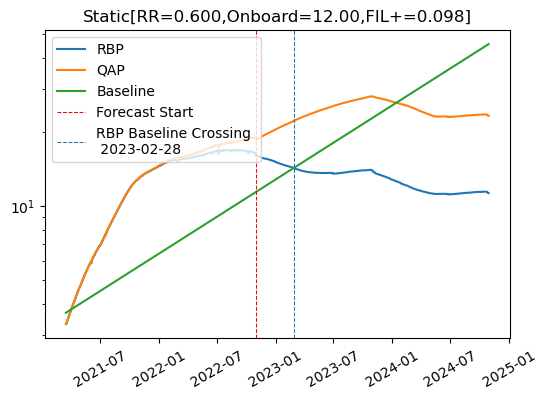

In [641]:
# BASELINE_B0 = 2.88888888 # should be this
BASELINE_B0 = 2.7636 # this value is required to match sentinel
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880
def baseline_storage(epoch: float)->float:
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

f, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
ax.plot(power_df.date, power_df.total_qa_power_eib, label='QAP')
ax.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
ax.axvline(current_date, color='red', linestyle='--', lw=0.75, label='Forecast Start')
ax.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Baseline Crossing \n %s' % (rb_crossing_below,))
for tick in ax.get_xticklabels(): tick.set_rotation(30)

ax.set_yscale('log')
plt.legend(loc='upper left')
plt.title(plt_title_str)

# np.sum(rewards_df.new_baseline_power.pipe(lambda x : x / (2**60)).values[:500]-baseline_storage(mint_df.days * EPOCH_PER_DAY).values[:500])

#### check minting

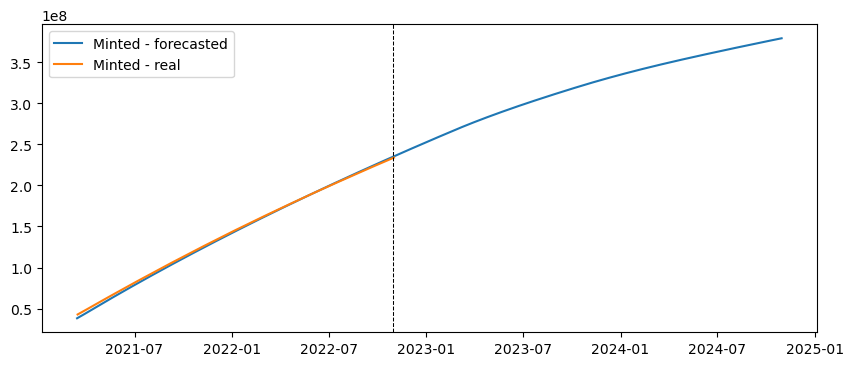

In [642]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['cum_network_reward'], label="Minted - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['mined_fil'],label="Minted - real")
plt.axvline(mint_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 5. Compute circulating supply

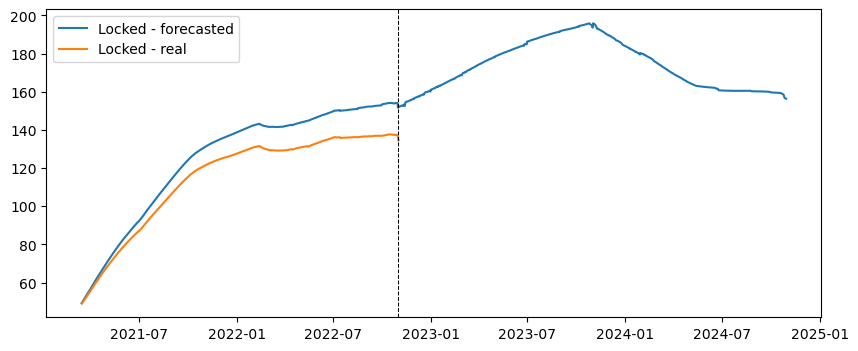

In [643]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_date,
    current_date,
    end_date,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate_vec,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)
MEGA = 10 ** 6
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

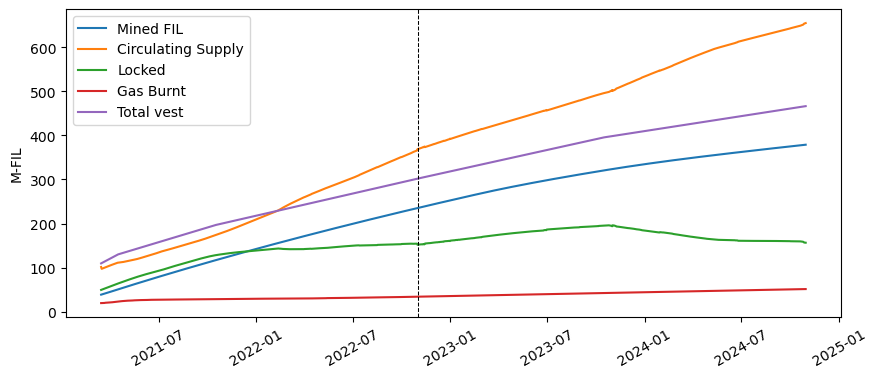

In [644]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

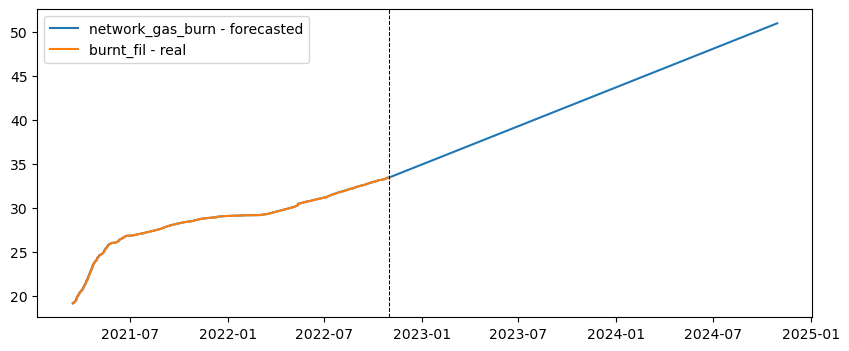

In [645]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="network_gas_burn - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['burnt_fil'] / MEGA,label="burnt_fil - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

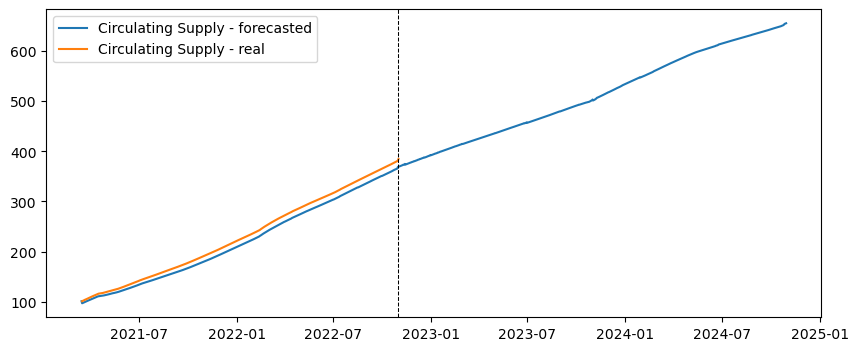

In [646]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

### Compute FoFR

In [647]:
def compute_sector_pledge(s, m, q, sector_df):
    # Get relevant variables
    qa_power_zero = sector_df["network_QAP"].iloc[0]
    circ_supply_zero = sector_df["circ_supply"].iloc[0]
    day_rewards_zero = sector_df["day_network_reward"].iloc[0]
    # compute pledge
    numerator = m * s * (20.0 * day_rewards_zero +  q * circ_supply_zero)
    pledge = numerator/qa_power_zero
    return pledge

def compute_sector_gas(d):
    total_gas = 0.00363 + 0.0119 + 0.00358 * (d/365.0)
    return total_gas

def compute_sector_rewards(s, m, sector_df):
    # Get relevant variables
    qa_power = sector_df["network_QAP"].values
    circ_supply = sector_df["circ_supply"].values
    day_rewards = sector_df["day_network_reward"].values
    # compute rewards
    total_rewards = sum(day_rewards[1:] / qa_power[1:])
    sector_rewards = m * s * total_rewards
    return sector_rewards
    
def compute_annualized_fofr_for_sector(seal_day, s, d, m, q, df):
    # Filter data to get sector days
    sector_df = df[df["days"].between(seal_day, seal_day+d)].sort_values("days").reset_index(drop=True)
    # Compute sector rewards, gas and pledge
    rewards = compute_sector_rewards(s, m, sector_df)
    gas = compute_sector_gas(d)
    pledge = compute_sector_pledge(s, m, q, sector_df)
    # Compute annualized return
    total_return = (rewards-gas+pledge)/pledge
    d_years = float(d)/365.0
    annualized_return = (total_return)**(1/d_years)-1
    return annualized_return, pledge

def compute_annualized_fofr_path(sector_size, sector_d, sector_fil_m, filtered_df):
    lock_target = filtered_df["lock_target"].iloc[0]
    duration_slope = filtered_df["slope"].iloc[0]
    if duration_slope is None:
        sector_m = sector_fil_m
    else:
        sector_m = sector_fil_m * duration_slope * (sector_d/365)
    fofr_list = []
    pledge_list = []
    for seal_day in filtered_df["days"][:-sector_d].values:
        fofr, pledge = compute_annualized_fofr_for_sector(seal_day, sector_size, sector_d, sector_m, lock_target, filtered_df)
        fofr_list.append(fofr)
        pledge_list.append(pledge)
    d = sector_d/365
    fofr_df = pd.DataFrame({
        "date": pd.to_datetime(filtered_df["date"].iloc[:-sector_d].values),
        "fofr": fofr_list,
        "total_fofr": (np.array(fofr_list)+1)**d-1,
        "lock_target": filtered_df["lock_target"].iloc[:-sector_d].values,
        "avg_dur": filtered_df["avg_dur"].iloc[:-sector_d].values,
        "slope": filtered_df["slope"].iloc[:-sector_d].values,
        "pledge": pledge_list,
    })
    return fofr_df

def compute_annualized_fofr_for_df(df, sector_size, sector_d, sector_fil_m):
    fofr_list = []
    n_sims = int(len(df)/N_DAYS)
    for i in range(n_sims):
        start = N_DAYS * i
        end = N_DAYS * (i+1)
        filtered_df = df.iloc[start:end]
#         print('sim=%d' % (i,), filtered_df['date'].iloc[0], filtered_df['date'].iloc[-1])
        sim_fofr_df = compute_annualized_fofr_path(sector_size, sector_d, sector_fil_m, filtered_df)
        fofr_list.append(sim_fofr_df)
    fofr_df = pd.concat(fofr_list)
    return fofr_df

In [648]:
fofr_df_rbp = cil_df[['date', 'days_x', 'network_QAP', 'day_network_reward', 'circ_supply']]
fofr_df_rbp = fofr_df_rbp.rename(columns={'days_x': 'days'})
fofr_df_rbp['duration_m'] = 'base'
fofr_df_rbp['lock_target'] = 0.3
fofr_df_rbp['avg_dur'] = 1
fofr_df_rbp['slope'] = 1

# print(len(fofr_df_rbp))

# TODO: it might be useful to eventually move this into minting.py
fofr_df_qap = cil_df.copy()
fofr_df_qap = fofr_df_qap.rename(columns={'days_x': 'days'})
fofr_df_qap['qap_capped_power'] = np.min(fofr_df_qap[["network_baseline", "network_QAP"]].values, axis=1)
zero_cum_qap_capped_power = get_cum_capped_qa_power(start_date)
fofr_df_qap["qap_cum_capped_power"] = fofr_df_qap["qap_capped_power"].cumsum() + zero_cum_qap_capped_power
fofr_df_qap["qap_network_time"] = fofr_df_qap["qap_cum_capped_power"].pipe(network_time)
fofr_df_qap["qap_cum_baseline_reward"] = fofr_df_qap["qap_network_time"].pipe(cum_baseline_reward)
# Add cumulative rewards and get daily rewards minted
fofr_df_qap["qap_cum_network_reward"] = fofr_df_qap["qap_cum_baseline_reward"] + fofr_df_qap["cum_simple_reward"]
fofr_df_qap["day_network_reward"] = fofr_df_qap["qap_cum_network_reward"].diff().fillna(method="backfill")
fofr_df_qap['duration_m'] = 'base'
fofr_df_qap['lock_target'] = 0.3
fofr_df_qap['avg_dur'] = 1
fofr_df_qap['slope'] = 1

In [649]:
GIB = 2**30
sector_size = 32 * GIB
sector_d = int(365/1.)   # sector duration
sector_fil_m = 10.0
N_DAYS = len(fofr_df_rbp)  # TODO: I'm not sure what is the correct configuration of this??

base_1y_fil_df_rbp_network_reward = compute_annualized_fofr_for_df(fofr_df_rbp, sector_size, sector_d, sector_fil_m)
base_1y_fil_df_qap_network_reward = compute_annualized_fofr_for_df(fofr_df_qap, sector_size, sector_d, sector_fil_m)
# print(len(base_1y_fil_df_rbp_network_reward), len(base_1y_fil_df_qap_network_reward))

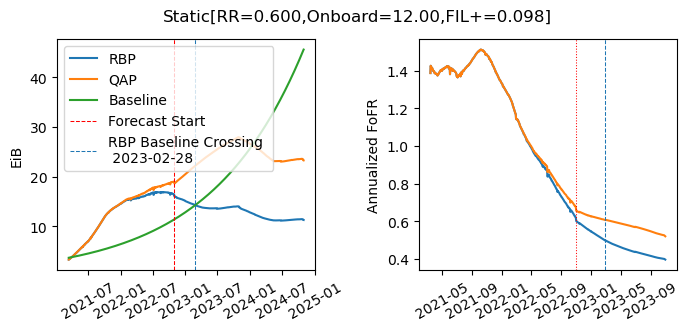

In [650]:
plt.figure(figsize=(8,3))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0:2, 0])
plt.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
plt.plot(power_df.date, power_df.total_qa_power_eib, label='QAP')
plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
plt.axvline(current_date, color='red', linestyle='--', lw=0.75, label='Forecast Start')
plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Baseline Crossing \n %s' % (rb_crossing_below,))
plt.xticks(rotation=30)
plt.legend(loc='upper left')
plt.ylabel('EiB')

plt.subplot(grid[0:2, 1])
plt.plot(base_1y_fil_df_rbp_network_reward['date'], base_1y_fil_df_rbp_network_reward['fofr'], label='RBP')
plt.plot(base_1y_fil_df_qap_network_reward['date'], base_1y_fil_df_qap_network_reward['fofr'], label='QAP')
plt.axvline(current_date, color='red', linestyle=':', lw=0.75)
plt.axvline(rb_crossing_below, linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel('Annualized FoFR')

plt.suptitle(plt_title_str)
# plt.subplots_adjust(bottom=0.01)
plt.tight_layout()

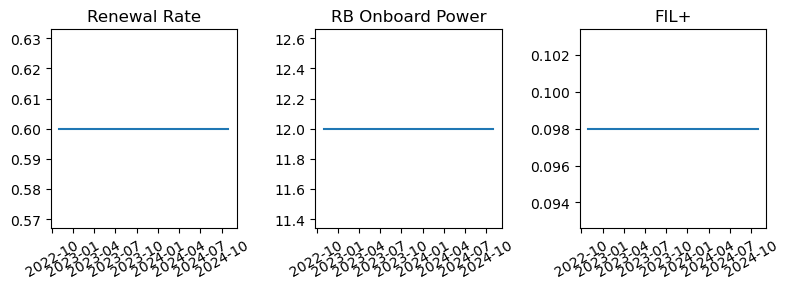

In [651]:
x = power_df[power_df['date'] >= current_date]

f, ax = plt.subplots(1,3,figsize=(8,3))
ax[0].plot(x.date, renewal_rate_vec_pred)
ax[0].set_title('Renewal Rate')

if isinstance(rb_onboard_power_pred, numbers.Number):
    ax[1].plot(x.date, np.ones(forecast_lenght)*rb_onboard_power_pred)
else:
    ax[1].plot(x.date, rb_onboard_power_pred)
ax[1].set_title('RB Onboard Power')
    
if isinstance(fil_plus_rate_pred, numbers.Number):
    ax[2].plot(x.date, np.ones(forecast_lenght)*fil_plus_rate_pred)
else:
    ax[2].plot(x.date, fil_plus_rate_pred)
ax[2].set_title('FIL+')

for tick in ax[0].get_xticklabels(): tick.set_rotation(30)
for tick in ax[1].get_xticklabels(): tick.set_rotation(30)
for tick in ax[2].get_xticklabels(): tick.set_rotation(30)

plt.tight_layout()